In [5]:
import cobra
import json
 
# Load the model
model = cobra.io.read_sbml_model(r"/Users/yahyafarooqi/Documents/Code/AntiGEM/FluxGraph/Models/Standard/subtilis_ iYO844.xml")
 
 
# Run pFBA
pfba = cobra.flux_analysis.pfba(model)
 
# Initialize an empty dictionary to store the results
reaction_stoichiometry = {}
 
# Iterate over all reactions in the model
for reaction in model.reactions:
    # Determine the multiplier based on the direction of the flux
    multiplier = -1 if pfba.fluxes[reaction.id] < 0 else 1
 
    # Initialize a dictionary for the current reaction with an additional entry for flux
    reaction_stoichiometry[reaction.id] = {
        'flux': pfba.fluxes[reaction.id],  # Store the flux of the reaction
        'metabolites': {}  # Sub-dictionary to store metabolites and their stoichiometry, adjusted for flux direction
    }
    
    # Iterate over the metabolites of the current reaction
    for metabolite, stoichiometry in reaction.metabolites.items():
        # Store the stoichiometry of the current metabolite, adjusted for flux direction
        reaction_stoichiometry[reaction.id]['metabolites'][metabolite.id] = stoichiometry * multiplier
 
# Filtering out reactions with no flux
active_reaction_stoichiometry = {k: v for k, v in reaction_stoichiometry.items() if v['flux'] > 0}
 
# Remove specified metabolites from active_reaction_stoichiometry
#remove = ['h2o_c', 'h_c', 'h2o_e', 'h_e', 'h2o_p', 'atp_c', 'adp_c', 'nad_c', 'nadh_c', 'nadp_c', 'nadph_c', 'co2_c', 'pi_c', 'ppi_c']
remove = []
 
# Initialize an empty dictionary to store filtered results
reac = {}
#filter out 'Growth' reaction
 
 
# Iterate over the active reactions
for reaction_id, data in active_reaction_stoichiometry.items():
    # Filter out unwanted metabolites
    filtered_metabolites = {met: stoich for met, stoich in data['metabolites'].items() if met not in remove}
    if filtered_metabolites:  # Only add if there are remaining metabolites after filtering
        reac[reaction_id] = {
            'flux': data['flux'],
            'metabolites': filtered_metabolites
        }
 
#remove "Growth" reaction from the dictionary
 
 
#reac.pop('Growth', None)
 
 
# Print the resulting filtered nested dictionary
for reaction, data in reac.items():
    print(f"{reaction}: Flux={data['flux']}, Metabolites={data['metabolites']}")

EX_co2_e: Flux=5.980675626921091, Metabolites={'co2_e': -1.0}
EX_h2o_e: Flux=7.869819466974072, Metabolites={'h2o_e': -1.0}
EX_h_e: Flux=0.7676647449584358, Metabolites={'h_e': -1.0}
2S6HCCi: Flux=3.1379059560002525e-05, Metabolites={'akg_c': -1.0, 'h_c': -1.0, 'ichor_c': -1.0, '2shchc_c': 1.0, 'co2_c': 1.0, 'pyr_c': 1.0}
FDH: Flux=0.0009328772152005734, Metabolites={'for_c': -1.0, 'nad_c': -1.0, 'co2_c': 1.0, 'nadh_c': 1.0}
FBA: Flux=1.583674798407074, Metabolites={'fdp_c': -1.0, 'dhap_c': 1.0, 'g3p_c': 1.0}
ACACT2r: Flux=0.003300227707709138, Metabolites={'accoa_c': -1.0, 'btcoa_c': -1.0, '3ohcoa_c': 1.0, 'coa_c': 1.0}
ACACT3r: Flux=0.003300227707709138, Metabolites={'accoa_c': -1.0, 'hxcoa_c': -1.0, '3oocoa_c': 1.0, 'coa_c': 1.0}
ACACT4r: Flux=0.003300227707709138, Metabolites={'accoa_c': -1.0, 'occoa_c': -1.0, '3odcoa_c': 1.0, 'coa_c': 1.0}
ACACT5r_1: Flux=0.003300227707709138, Metabolites={'accoa_c': -1.0, 'dccoa_c': -1.0, '3oddcoa_c': 1.0, 'coa_c': 1.0}
ACACT6r_1: Flux=0.00330022

/var/folders/hz/wkcmpvw53bb87st6wdf8j_cw0000gp/T/ipykernel_31446/3702795888.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


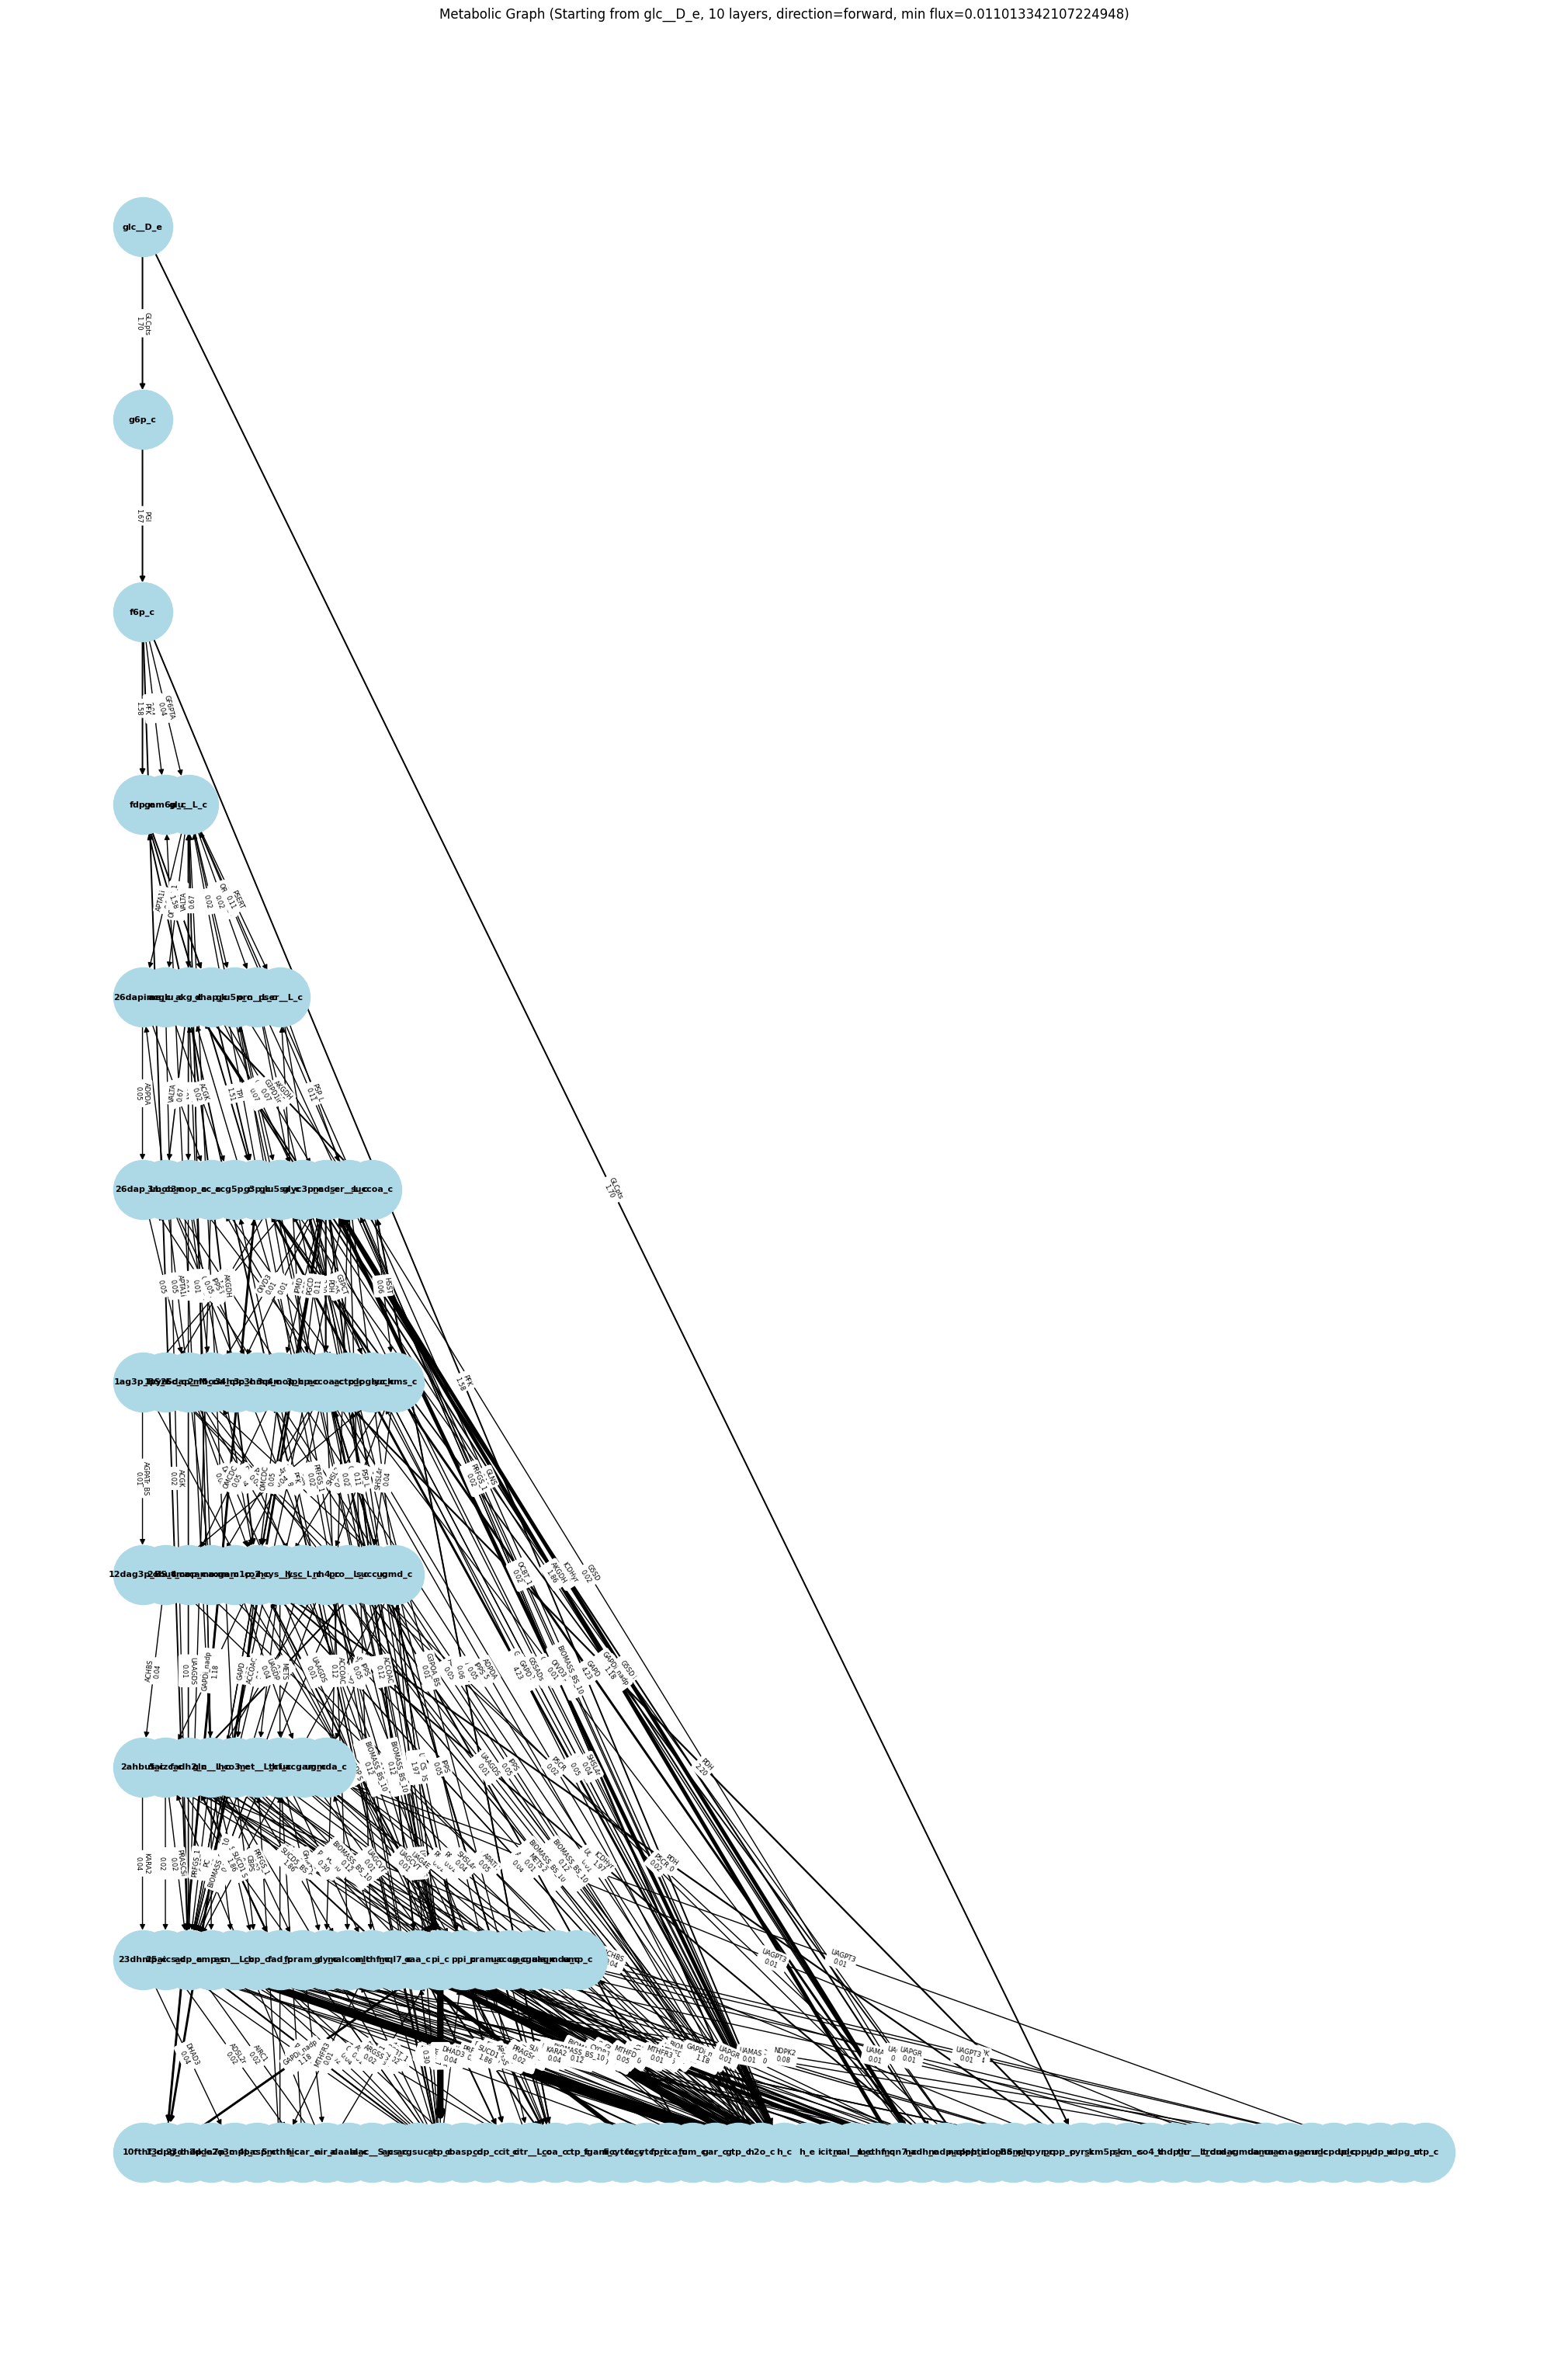

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
 
def create_metabolic_graph(reac, primary_source, layers, direction='forward', min_flux=0, remove=None, target_metabolite=None):
    if remove is None:
        remove = []
    
    G = nx.DiGraph()
    layer_nodes = defaultdict(set)
    all_layer_nodes = set()
    
    def add_layer(metabolite, current_layer, current_direction):
        if current_layer > layers or metabolite in remove:
            return
        
        layer_nodes[current_layer].add(metabolite)
        all_layer_nodes.add(metabolite)
        
        for reaction, data in reac.items():
            if metabolite in data['metabolites'] and abs(data['flux']) >= min_flux:
                stoich = data['metabolites'][metabolite]
                
                if current_direction in ['forward', 'both'] and stoich < 0:
                    for product, prod_stoich in data['metabolites'].items():
                        if product != metabolite and prod_stoich > 0 and product not in remove:
                            G.add_edge(metabolite, product, reaction=reaction, flux=abs(data['flux']))
                            if product not in all_layer_nodes:
                                add_layer(product, current_layer + 1, 'forward')
                
                if current_direction in ['backward', 'both'] and stoich > 0:
                    for reactant, react_stoich in data['metabolites'].items():
                        if reactant != metabolite and react_stoich < 0 and reactant not in remove:
                            G.add_edge(reactant, metabolite, reaction=reaction, flux=abs(data['flux']))
                            if reactant not in all_layer_nodes:
                                add_layer(reactant, current_layer + 1, 'backward')
    
    add_layer(primary_source, 0, direction)
    
    if len(G.nodes) == 0:
        print("No nodes were added to the graph.")
        return
    
    # Ensure all nodes are in layer_nodes
    for node in G.nodes():
        if node not in all_layer_nodes:
            layer_nodes[layers].add(node)
            all_layer_nodes.add(node)
    
    # Create a more organized layout
    pos = {}
    for layer, nodes in layer_nodes.items():
        y = -layer if direction != 'backward' else layer
        for i, node in enumerate(sorted(nodes)):
            pos[node] = (i, y)
    
    plt.figure(figsize=(20, 30))
    
    # Calculate edge widths based on flux
    edge_fluxes = [d['flux'] for (u, v, d) in G.edges(data=True)]
    max_flux = max(edge_fluxes)
    min_flux = min(edge_fluxes)
    edge_widths = [1 + 5 * (d['flux'] - min_flux) / (max_flux - min_flux) for (u, v, d) in G.edges(data=True)]
    
    # Draw the main graph
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=8,
            font_weight='bold', arrows=True, width=edge_widths)
    
    # Highlight path if target_metabolite is specified
    if target_metabolite and target_metabolite in G.nodes():
        try:
            paths = list(nx.all_simple_paths(G, source=primary_source, target=target_metabolite))
            if paths:
                path_edges = set()
                for path in paths:
                    path_edges.update(zip(path[:-1], path[1:]))
                nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=2)
                nx.draw_networkx_nodes(G, pos, nodelist=[primary_source, target_metabolite], node_color='yellow', node_size=3500)
            else:
                print(f"No path found between {primary_source} and {target_metabolite}")
        except nx.NetworkXNoPath:
            print(f"No path found between {primary_source} and {target_metabolite}")
    
    edge_labels = {(u, v): f"{d['reaction']}\n{d['flux']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)
    
    plt.title(f"Metabolic Graph (Starting from {primary_source}, {layers} layers, direction={direction}, min flux={min_flux})")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
 
# Example usage:
#remove = ['h2o_c', 'h_c', 'h2o_e', 'h_e', 'h2o_p', 'atp_c', 'adp_c', 'nad_c', 'nadh_c', 'nadp_c', 'nadph_c', 'co2_c', 'pi_c', 'ppi_c']
create_metabolic_graph(reac, 'glc__D_e', 10, direction='forward', min_flux=0.01, remove=remove)

In [ ]:


model.reactions.get_by_id('PYK').metabolites.keys()

dict_keys([<Metabolite adp_c at 0x15aeee150>, <Metabolite h_c at 0x15ddb5010>, <Metabolite pep_c at 0x136aaa240>, <Metabolite atp_c at 0x161067800>, <Metabolite pyr_c at 0x15de33920>])

In [3]:
import re

# Function to count carbon atoms in a chemical formula
def count_carbon_atoms(formula):
    match = re.search(r'C(\d*)', formula)
    if match:
        return int(match.group(1)) if match.group(1) else 1
    return 0

# Function to calculate the most carbon-rich product of a reaction
def get_max_carbon_product(reaction_id):
    reaction = model.reactions.get_by_id(reaction_id)
    max_carbon = 0
    max_carbon_metabolite = None

    for metabolite, stoich in reaction.metabolites.items():
        if stoich > 0:  # Only consider products (positive stoichiometry)
            if metabolite.formula:  # Ensure the formula is not None
                carbon_count = count_carbon_atoms(metabolite.formula)
                if carbon_count > max_carbon:
                    max_carbon = carbon_count
                    max_carbon_metabolite = metabolite.id

    return max_carbon, max_carbon_metabolite

# Create a dictionary of reactions ranked by the most carbon-rich product
reaction_carbon_ranking = {
    reaction.id: get_max_carbon_product(reaction.id) for reaction in model.reactions
}

# Sort reactions by the maximum carbon count
sorted_reactions = sorted(
    reaction_carbon_ranking.items(), key=lambda x: x[1][0], reverse=True
)

# Print the sorted ranking
print("Ranking of reactions by most carbon-rich product:")
for rank, (reaction_id, (max_carbon, metabolite_id)) in enumerate(sorted_reactions, start=1):
    print(f"{rank}. Reaction: {reaction_id}, Max Carbon: {max_carbon}, Metabolite: {metabolite_id}")

Ranking of reactions by most carbon-rich product:
1. Reaction: LIPO2S24_BS, Max Carbon: 31036, Metabolite: lipo2_24_BS_c
2. Reaction: LIPO1S24_BS, Max Carbon: 26236, Metabolite: lipo1_24_BS_c
3. Reaction: LIPO3S24_BS, Max Carbon: 19036, Metabolite: lipo3_24_BS_c
4. Reaction: LIPO4S24_BS, Max Carbon: 11836, Metabolite: lipo4_24_BS_c
5. Reaction: CLPNS2_BS, Max Carbon: 7172, Metabolite: cdlp_BS_c
6. Reaction: UGT2_BS, Max Carbon: 5236, Metabolite: t12dg_BS_c
7. Reaction: UGT_BS, Max Carbon: 4636, Metabolite: d12dg_BS_c
8. Reaction: LYSLG_BS, Max Carbon: 4336, Metabolite: lysylpgly_BS_c
9. Reaction: PHCYT_BS, Max Carbon: 4336, Metabolite: cdpdag_BS_c
10. Reaction: UGT1_BS, Max Carbon: 4036, Metabolite: m12dg_BS_c
11. Reaction: CDGPT_BS, Max Carbon: 3736, Metabolite: pglyp_BS_c
12. Reaction: CDPDSP_BS, Max Carbon: 3736, Metabolite: ps_BS_c
13. Reaction: PGPPH_BS, Max Carbon: 3736, Metabolite: pgly_BS_c
14. Reaction: PSDC_BS, Max Carbon: 3636, Metabolite: psetha_BS_c
15. Reaction: AGPATr_BS

In [ ]:
import cobra


# Load the model

AttributeError: 'list' object has no attribute 'items'

In [14]:
print(metabolite)

glc__D_e
